# Análisis de Series Temporales
#### Primer trabajo práctico
---
**Alumnos:** Novaresse, Pagani, Edgar  
**Fecha:** 23 de Junio de 2025  
**Descripción:** Forecast en variables macroeconómicas

#### 1. Introducción
Este trabajo práctico analiza la serie temporal del **Estimador Mensual de Actividad Económica (EMAE)**, índice base 2004, con datos mensuales desde enero de 2004 hasta marzo de 2025. El objetivo es modelar la serie usando AR, MA, ARMA, ARIMA, SARIMA y SARIMAX, comparando su desempeño con métricas como AIC, BIC, MSE, MAE y RMSE, y generar pronósticos a 12 meses (hasta marzo 2026). Se incluirá una variable dummy para la crisis de COVID-19 (marzo-diciembre 2020) como variable exógena para proponer un modelo SARIMAX. 

#### 2. Importar librerías necesarias

In [2]:
# Creo un environment que tenga las versiones compatibles de Numpy y PMDarima
!conda create -y -n ts_env \
    -c conda-forge \
    python=3.11 \
    numpy=1.24.4 \
    pandas \
    matplotlib \
    seaborn \
    statsmodels \
    scipy \
    pmdarima \
    scikit-learn \
    ipykernel

!conda run -n ts_env python -m ipykernel install --user --name ts_env --display-name "Python (ts_env)"

Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\ianed\anaconda3\envs\ts_env

  added / updated specs:
    - ipykernel
    - matplotlib
    - numpy=1.24.4
    - pandas
    - pmdarima
    - python=3.11
    - scikit-learn
    - scipy
    - seaborn
    - statsmodels


The following NEW packages will be INSTALLED:

  _openmp_mutex      conda-forge/win-64::_openmp_mutex-4.5-2_gnu 
  asttokens          conda-forge/noarch::asttokens-3.0.0-pyhd8ed1ab_1 
  brotli             conda-forge/win-64::brotli-1.1.0-h2466b09_3 
  brotli-bin         conda-forge/win-64::brotli-bin-1.1.0-h2466b09_3 
  brotli-python      conda-forge/win-64::brotli-python-1.1.0-py311hda3d55a_3 
  bzip2              conda-forge/win-64::bzip2-1.0.8-h2466b09_7 
  ca-certificates    conda-forge/noarch::ca-certificates-2025.7.9-h4c7d964_0 
  cairo              conda-forge/win-64::cairo-1.18.4-h5782bbf_0 
  cffi               conda-f

In [4]:
# Cargamos librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_ccf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy.stats import jarque_bera, shapiro, probplot, boxcox
!pip install pmdarima
from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from datetime import timedelta
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   -- ------------------------------------ 41.0/625.1 kB 653.6 kB/s eta 0:00:01
   --------- ------------------------------ 153.6/625.1 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --------------------------- ------------ 1.9/2.7 MB 39.2 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 34.4 MB/s eta 0:00:00


----
## 3. Carga y exploración de los datos

In [8]:
# Cargamos los datos
ruta = r"C:\Users\ianed\Desktop\Universidad Austral\Segundo año\Segundo bimestre\Análisis de Series Temporales\faena-pecuaria-por-especies-valores-mensuales.csv"
df_faena = pd.read_csv(ruta, parse_dates=['indice_tiempo'])

# Dejamos solo la serie temporal y la columna de vacunos en toneladas
df_faena = df_faena[['indice_tiempo', 'vacunos_toneladas']]
df_faena.set_index('indice_tiempo', inplace=True)
df_faena = df_faena.iloc[217:]
df_faena.index.freq = 'MS'  # Frecuencia mensual
df_faena.head()

,vacunos_toneladas
indice_tiempo,
1998-02-01,191886.543797
1998-03-01,211443.753844
1998-04-01,200011.872873
1998-05-01,193451.778768
1998-06-01,195322.380647


In [9]:
# Verificamos que el indice sea del tipo DatetimeIndex
print(df_faena.index)

# OK! datetime, y frecuencia mensual

DatetimeIndex(['1998-02-01', '1998-03-01', '1998-04-01', '1998-05-01',
               '1998-06-01', '1998-07-01', '1998-08-01', '1998-09-01',
               '1998-10-01', '1998-11-01',
               ...
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01',
               '2025-04-01', '2025-05-01'],
              dtype='datetime64[ns]', name='indice_tiempo', length=328, freq='MS')


In [10]:
# Verificamos la existencia de valores nulos
print("Valores faltantes:")
print(df_faena.isnull().values.any())

Valores faltantes:
False


In [12]:
# Estadísticas descriptivas
print("Estadísticas Descriptivas:")
print(df_faena.describe())

Estadísticas Descriptivas:
       vacunos_toneladas
count         328.000000
mean       240687.267179
std         28455.817202
min        152362.417426
25%        218771.492463
50%        237070.988925
75%        261786.082093
max        311260.135274


#### Visualización y descomposición de la serie 

In [13]:
# Función para graficar
def graficar(serie, titulo='', xlabel='', ylabel='', figsize=(10, 3), usar_leyenda=False, label=''):
    plt.figure(figsize=figsize)
    if usar_leyenda:
        plt.plot(serie, label=label)
        plt.legend()
    else:
        plt.plot(serie)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

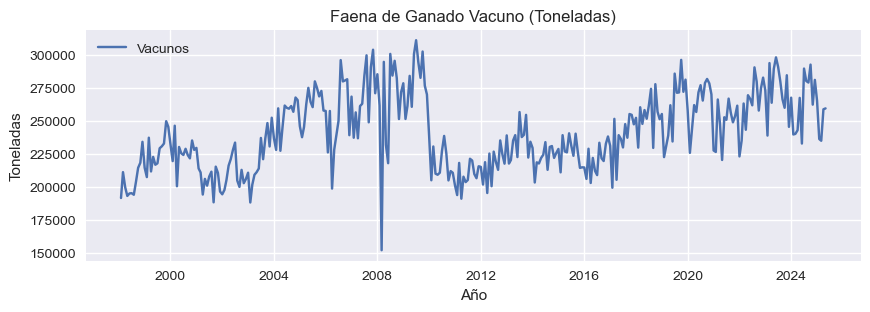

In [15]:
# Visualizamos la faena de ganado vacuno en toneladas
graficar(df_faena['vacunos_toneladas'],
         titulo='Faena de Ganado Vacuno (Toneladas)',
         xlabel='Año', ylabel='Toneladas', figsize=(10, 3),
         usar_leyenda=True, label='Vacunos')


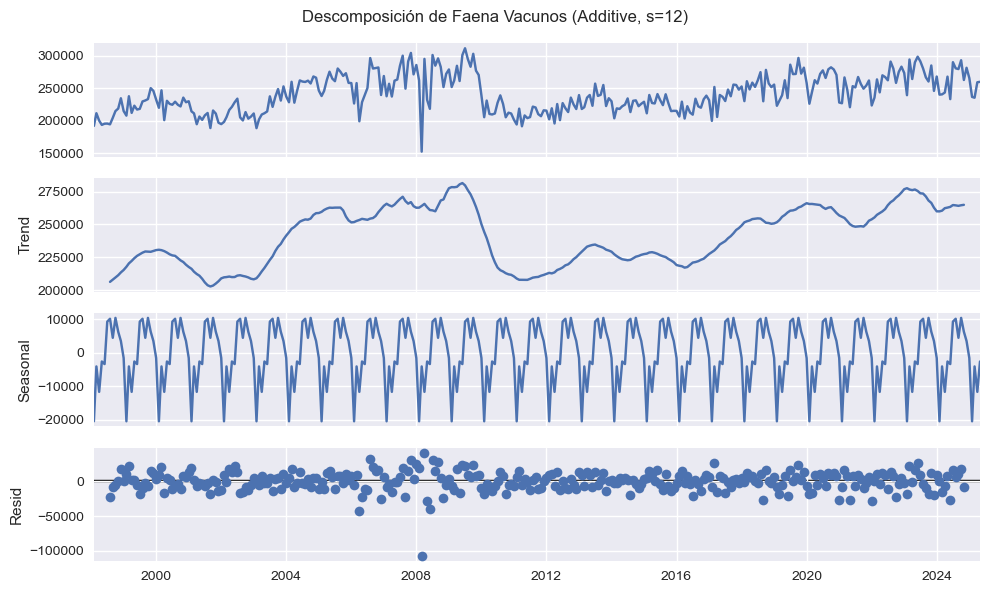

In [16]:
# Descomposición de la serie en componentes (tendencia, estacionalidad, residual)
decomp = seasonal_decompose(df_faena, model='additive', period=12)
fig = decomp.plot()
fig.set_size_inches(10, 6)
plt.suptitle('Descomposición de Faena Vacunos (Additive, s=12)')
plt.tight_layout()
plt.show()

----
## 4. Análisis de estacionariedad

#### ACF, PACF, Autocovarianzas 

In [17]:
# Función para graficar ACF, PACF, autocovarianzas
# Fue construida a partir de la función utilizada en un notebook del profesor, y con ChatGPT se le pidió que la reformule para que sea aplicable a una
# serie, y no dos. 
def graficar_acf_pacf_autocov(serie, n_lags=50, titulo="Análisis de correlación temporal"):
    fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True)

    fig.suptitle(titulo, fontsize=12)

    # ACF
    plot_acf(serie, lags=n_lags, ax=axes[0], color='blue', 
             vlines_kwargs={"colors": 'blue'}, title="Autocorrelación (ACF)")

    # PACF
    plot_pacf(serie, lags=n_lags, ax=axes[1], color='green', 
              vlines_kwargs={"colors": 'green'}, method='ywm', title="Autocorrelación Parcial (PACF)")

    # Autocovarianzas
    autocov = tsa.acovf(serie, fft=False, nlag=n_lags)
    axes[2].plot(autocov, color='red')
    axes[2].set_title("Autocovarianzas")
    axes[2].set_xlabel("Lag")

    plt.tight_layout()
    plt.show()

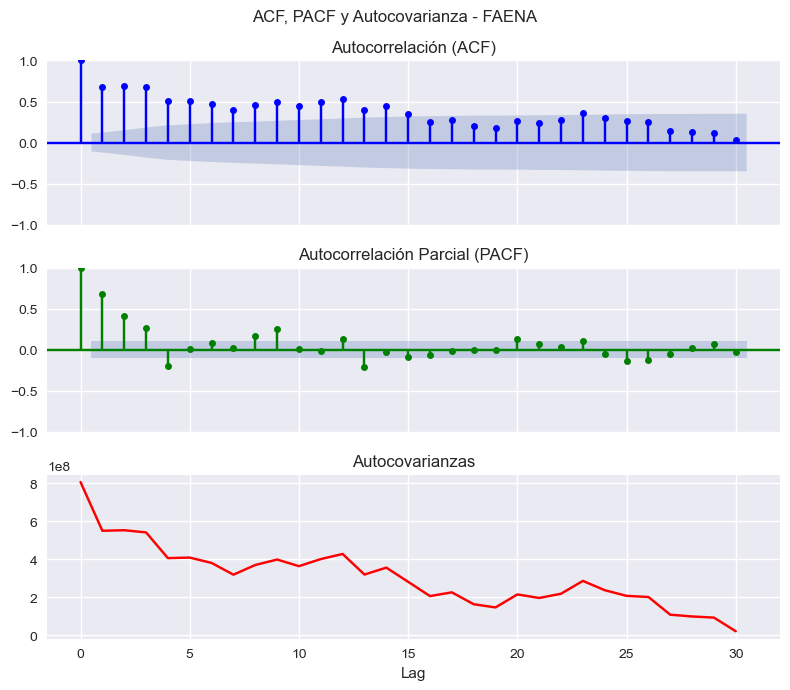

In [18]:
# Graficamos 
graficar_acf_pacf_autocov(df_faena, n_lags=30, 
                          titulo="ACF, PACF y Autocovarianza - FAENA")

- La ACF muestra una caída lenta y gradual, con valores significativamente distintos de cero incluso después de varios rezagos (lags). Este comportamiento sugiere no estacionariedad: cuando las autocorrelaciones se mantienen altas y decaen lentamente.
- La PACF muestra solo el primer rezago significativo, lo que sugiere que si la serie es estacionaria, un modelo AR(1) podría ajustarla bien. 
- Parece haber estacionalidad cada 12 lags...

#### Análisis de la primera diferencia de la serie

In [19]:
# Aplicamos primera diferencia, para ver si se puede eliminar la estacionariedad
faena_diff = df_faena.diff().dropna()

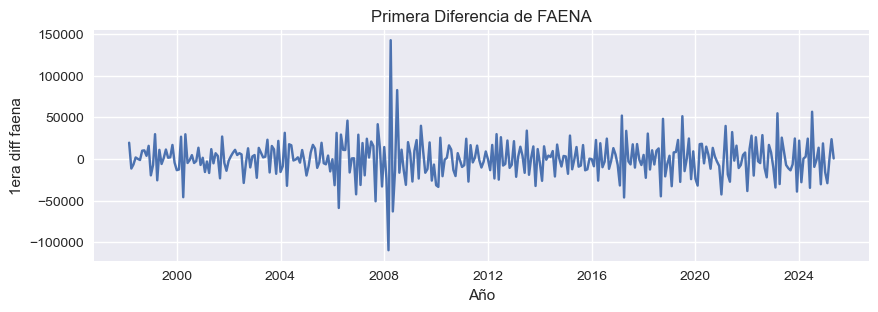

In [20]:
# Graficamos la primera diferencia
graficar(faena_diff, 
         titulo='Primera Diferencia de FAENA', 
         xlabel='Año', 
         ylabel='1era diff faena', 
         figsize=(10, 3))

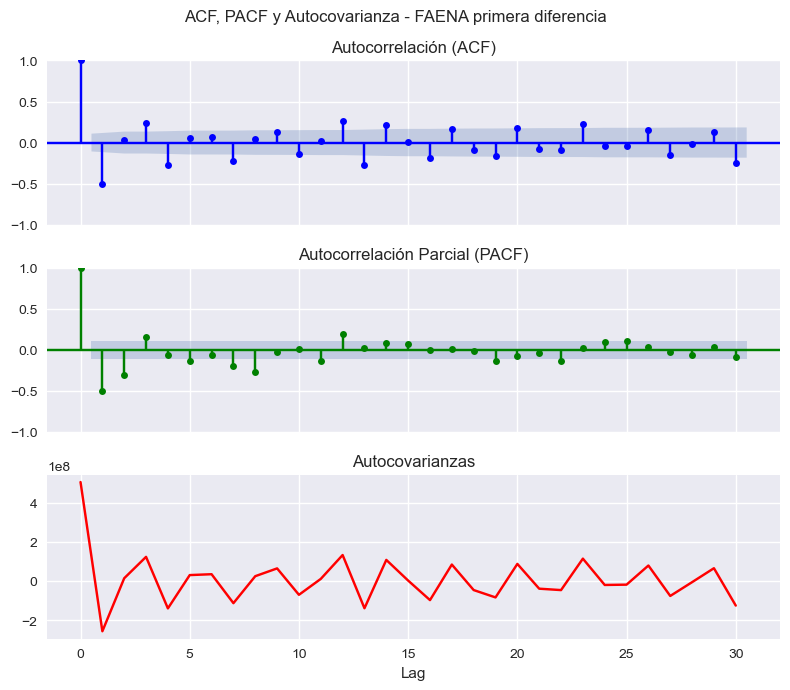

In [21]:
# Y su ACF, PACF y autocovarianzas
graficar_acf_pacf_autocov(faena_diff, n_lags=30, 
                          titulo="ACF, PACF y Autocovarianza - FAENA primera diferencia")

- La serie parece estacionaria tras la primera diferencia → d=1
- Hay indicios de estacionalidad de orden 12, tanto en ACF como PACF → posible componente estacional SARIMA con s=12
- Un modelo candidato podría ser SARIMA(1,1,0)(1,0,0)[12]

#### Test Dickey-Fuller Aumentado

In [22]:
# Función para realizar test ADF
# Se utiliza el mismo que proporcionó el profesor en la clase de práctica
# Se incorporó un componente adicional expresa si se rechaza o no la hipótesis nula del test, construido con ChatGPT

def print_test_adf(y):
    resultado = adfuller(y.dropna())
    estadistico_adf = resultado[0]
    p_valor = resultado[1]
    criticos = resultado[4]

    print('Estadístico ADF: %f' % estadistico_adf)
    print('p-valor: %f' % p_valor)
    print('Valores críticos:')
    for clave, valor in criticos.items():
        print(f'   {clave}: {valor:.3f}')

    if p_valor < 0.05:
        print("✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.")
    else:
        print("⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.")

In [23]:
# Testeamos la serie sin diferenciar
print_test_adf(df_faena)

Estadístico ADF: -2.529615
p-valor: 0.108434
Valores críticos:
   1%: -3.451
   5%: -2.871
   10%: -2.572
⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.


In [24]:
# Testeamos la serie diferenciada
print_test_adf(faena_diff)

Estadístico ADF: -6.462056
p-valor: 0.000000
Valores críticos:
   1%: -3.451
   5%: -2.871
   10%: -2.572
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


#### Componentes deterministicos - Test de Raíces Unitarias

In [25]:
# Función para realizar los tres test de raíces unitarias
# Función realizada con ChatGPT

def adf_test_multiple(series):
    opciones = {
        'n': 'Sin constante (None)',
        'c': 'Con constante (Drift)',
        'ct': 'Con constante y tendencia (Trend)'
    }

    for reg, descripcion in opciones.items():
        print(f"\n===== Test ADF - {descripcion} =====")
        resultado = adfuller(series.dropna(), regression=reg, autolag='AIC')
        estadistico = resultado[0]
        p_valor = resultado[1]
        criticos = resultado[4]

        print(f'Estadístico ADF: {estadistico:.4f}')
        print(f'p-valor: {p_valor:.4f}')
        print('Valores críticos:')
        for clave, valor in criticos.items():
            print(f'   {clave}: {valor:.3f}')

        if p_valor < 0.05:
            print("✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.")
        else:
            print("⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.")


In [27]:
# Testeamos la serie sin diferenciar
adf_test_multiple(df_faena)


===== Test ADF - Sin constante (None) =====
Estadístico ADF: 0.3691
p-valor: 0.7931
Valores críticos:
   1%: -2.573
   5%: -1.942
   10%: -1.616
⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estadístico ADF: -2.5296
p-valor: 0.1084
Valores críticos:
   1%: -3.451
   5%: -2.871
   10%: -2.572
⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estadístico ADF: -2.8620
p-valor: 0.1751
Valores críticos:
   1%: -3.988
   5%: -3.425
   10%: -3.135
⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.


In [28]:
# Testeamos la serie diferenciada
adf_test_multiple(faena_diff)


===== Test ADF - Sin constante (None) =====
Estadístico ADF: -6.4439
p-valor: 0.0000
Valores críticos:
   1%: -2.573
   5%: -1.942
   10%: -1.616
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estadístico ADF: -6.4621
p-valor: 0.0000
Valores críticos:
   1%: -3.451
   5%: -2.871
   10%: -2.572
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estadístico ADF: -6.4540
p-valor: 0.0000
Valores críticos:
   1%: -3.988
   5%: -3.425
   10%: -3.135
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


Es razonable considerar que la serie tenga un componente no estacional autorregresivo de orden 1, AR(1), es decir, p = 1.

#### Análisis de la segunda diferencia de la serie

In [29]:
# Calculamos la serie diferenciada dos veces
faena_diff_2 = faena_diff.diff().dropna()

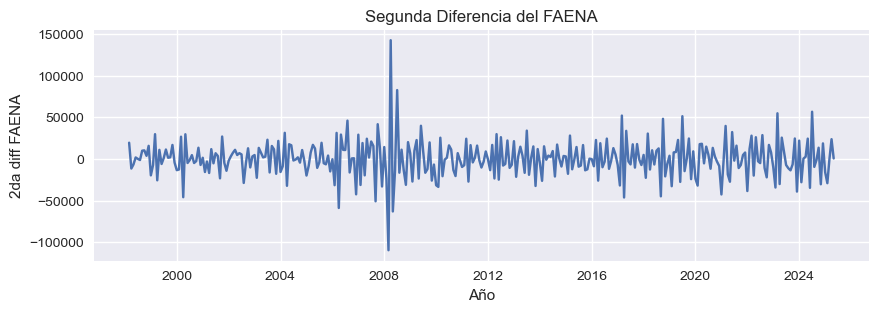

In [30]:
# Graficamos
graficar(faena_diff, 
         titulo='Segunda Diferencia del FAENA', 
         xlabel='Año', 
         ylabel='2da diff FAENA')

In [31]:
# Testeamos
print_test_adf(faena_diff_2)

Estadístico ADF: -11.445063
p-valor: 0.000000
Valores críticos:
   1%: -3.451
   5%: -2.871
   10%: -2.572
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


In [32]:
# Tesetamos raíces unitarias
adf_test_multiple(faena_diff_2)


===== Test ADF - Sin constante (None) =====
Estadístico ADF: -11.4635
p-valor: 0.0000
Valores críticos:
   1%: -2.573
   5%: -1.942
   10%: -1.616
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estadístico ADF: -11.4451
p-valor: 0.0000
Valores críticos:
   1%: -3.451
   5%: -2.871
   10%: -2.572
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estadístico ADF: -11.4288
p-valor: 0.0000
Valores críticos:
   1%: -3.988
   5%: -3.425
   10%: -3.135
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


#### Diferenciación
¿Cuántas veces debemos diferenciar? Realizamos diferentes tests para determinarlo. 

In [33]:
# Creamos una función que lleva a cabo diferentes tests de diferenciación óptima
# A partir de la proporcionada por el profesor, fine-tuneada con ChatGPT

def test_estacionariedad(y, alpha=0.05):
    print("🔍 Test de estacionariedad sugerida por distintos métodos")
    print("="*60)
    
    # Calcular cantidad de diferenciaciones sugeridas
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')

    print(f"📉 ADF test sugiere:   {n_adf} diferenciación(es)")
    print(f"📈 KPSS test sugiere: {n_kpss} diferenciación(es)")
    print(f"📉 PP test sugiere:    {n_pp} diferenciación(es)")
    print("-"*60)

    # Evaluar si al menos uno requiere diferenciación
    if any(test > 0 for test in [n_adf, n_kpss, n_pp]):
        print("⚠️ Al menos uno de los tests sugiere diferenciar → Se recomienda aplicar diferenciación.")
    else:
        print("✅ Ningún test sugiere diferenciar → La serie probablemente es estacionaria.")
    
    print("="*60)

In [34]:
test_estacionariedad(df_faena)

🔍 Test de estacionariedad sugerida por distintos métodos
📉 ADF test sugiere:   0 diferenciación(es)
📈 KPSS test sugiere: 1 diferenciación(es)
📉 PP test sugiere:    0 diferenciación(es)
------------------------------------------------------------
⚠️ Al menos uno de los tests sugiere diferenciar → Se recomienda aplicar diferenciación.


In [36]:
test_estacionariedad(faena_diff)

🔍 Test de estacionariedad sugerida por distintos métodos
📉 ADF test sugiere:   0 diferenciación(es)
📈 KPSS test sugiere: 0 diferenciación(es)
📉 PP test sugiere:    0 diferenciación(es)
------------------------------------------------------------
✅ Ningún test sugiere diferenciar → La serie probablemente es estacionaria.


- Observando los resultados de los tests, lo recomendable es aplicar una primera diferencia para eliminar la estacionariedad
- Esto implica que, en la construcción del modelo, tendremos un parámetro d=1

----
## 5. Análisis de estacionalidad

In [37]:
# Intuimos que la serie tiene estacionalidad cada 12 meses, por los gráficos de ACF y PACF
# Aplicamos la 12ava diferencia a la serie de faena
faena_diff_12 = df_faena - df_faena.shift(12)
faena_diff_12 = faena_diff_12.dropna()


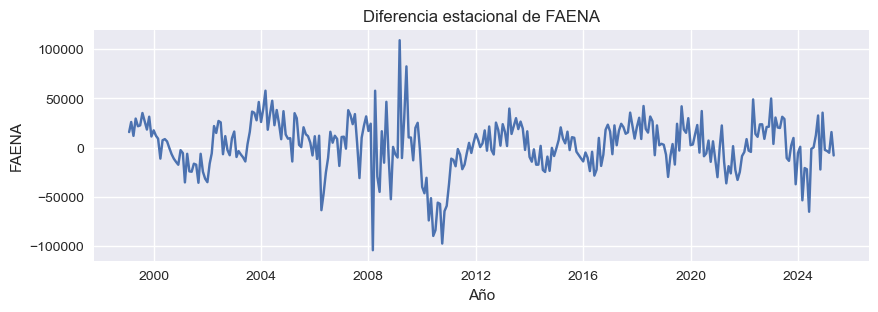

In [38]:
# Graficamos la serie
graficar(faena_diff_12, 
         titulo='Diferencia estacional de FAENA', 
         xlabel='Año', 
         ylabel='FAENA', 
         figsize=(10, 3))

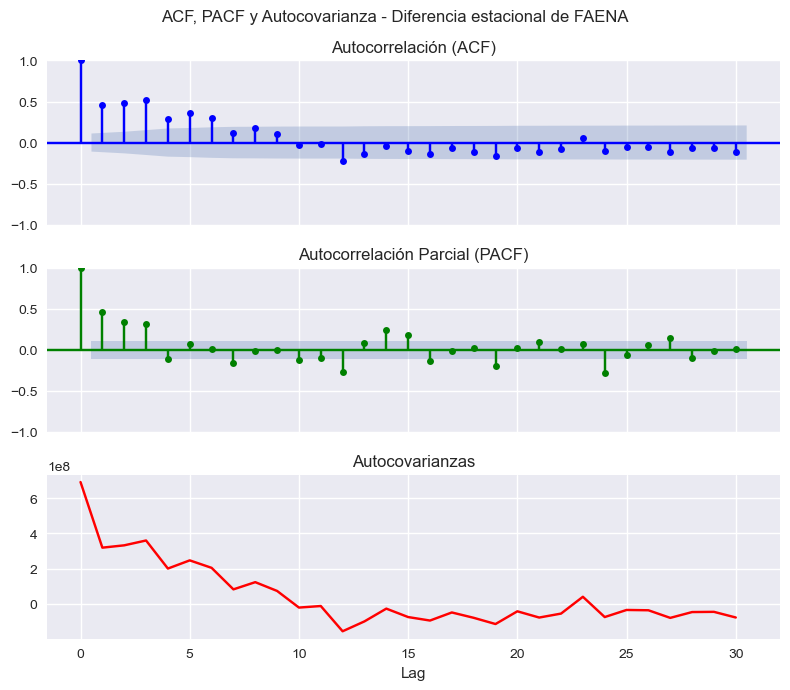

In [39]:
# ACF, PACF, Autocovarianzas
graficar_acf_pacf_autocov(faena_diff_12, n_lags=30, 
                          titulo="ACF, PACF y Autocovarianza - Diferencia estacional de FAENA")

In [40]:
# Aplicamos la doceava diferencia, a la primera diferencia de la serie
faena_diff_1_12 = faena_diff - faena_diff.shift(12)
faena_diff_1_12 = faena_diff_1_12.dropna()

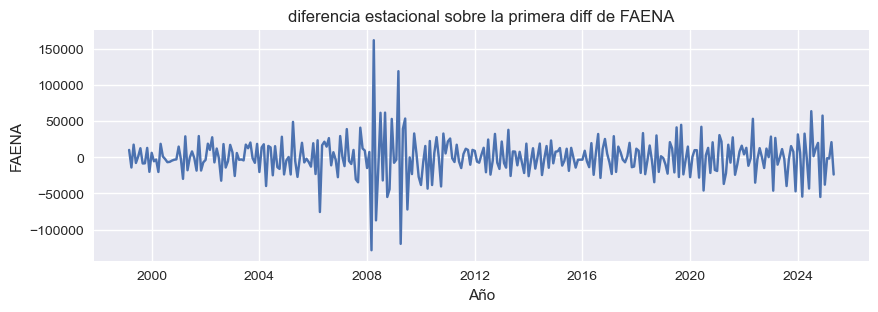

In [41]:
# Graficamos la serie
graficar(faena_diff_1_12, 
         titulo='diferencia estacional sobre la primera diff de FAENA', 
         xlabel='Año', 
         ylabel='FAENA', 
         figsize=(10, 3))

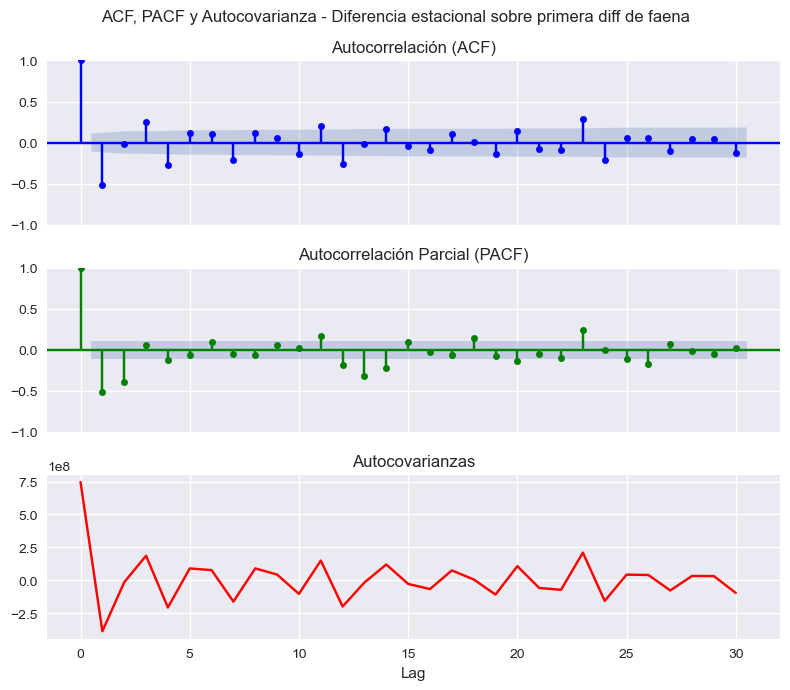

In [42]:
# ACF, PACF, Autocovarianzas
graficar_acf_pacf_autocov(faena_diff_1_12, n_lags=30, 
                          titulo="ACF, PACF y Autocovarianza - Diferencia estacional sobre primera diff de faena")

- Parece que ya se eliminó la estacionalidad. Hay lags significativos en meses 4, 8 y 18.


----
## 6. Analizar la posibilidad de transformación Box-Cox

Al analizar la serie gráficamente - específicamente el gráfico de la doceava diferencia estacional sobre la primera diferencia, existen indicios de heterocedasticidad, observando cambios en la magnitud de las fluctuaciones. Se realizará una transformación de Box-Cox a la serie original con el objetivo de estabilizar la varianza. Esto puede ayudar a que los residuos del modelo final sean más normales y con varianza constante.

#### Test de Jarque Bera para la normalidad de los residuos

In [43]:
# Creamos una función para el test Jarque Bera con ChatGPT 
def test_jarquebera(serie):
    jb_stat, jb_pvalue = jarque_bera(serie)

    print("===== Test de normalidad Jarque-Bera =====")
    print(f"Estadístico Jarque-Bera: {jb_stat:.4f}")
    print(f"p-valor: {jb_pvalue:.4f}")

    if jb_pvalue > 0.05:
        print("✅ No se rechaza la hipótesis nula: los residuos tienen distribución normal (al 5%)")
    else:
        print("❌ Se rechaza la hipótesis nula: los residuos NO siguen una distribución normal (al 5%)")

In [44]:
# Test sobre los datos originales 
test_jarquebera(df_faena)

===== Test de normalidad Jarque-Bera =====
Estadístico Jarque-Bera: 7.8583
p-valor: 0.0197
❌ Se rechaza la hipótesis nula: los residuos NO siguen una distribución normal (al 5%)


In [45]:
# Aplicamos la transformación Box-Cox
faena_boxcox, lambda_bc = boxcox(df_faena.values.flatten())
print(f"Lambda óptimo para Box-Cox: {lambda_bc}")

Lambda óptimo para Box-Cox: 0.1594704804817174


In [46]:
# Creamos la serie transformada con el mismo índice temporal
faena_boxcox = pd.Series(faena_boxcox, index=df_faena.index)

In [47]:
# Mostramos los primeros 5 valores
print("Primeros 5 valores de la serie transformada con Box-Cox:")
print(faena_boxcox[:5])

Primeros 5 valores de la serie transformada con Box-Cox:
indice_tiempo
1998-02-01    37.361671
1998-03-01    38.042240
1998-04-01    37.651197
1998-05-01    37.418235
1998-06-01    37.485332
Freq: MS, dtype: float64


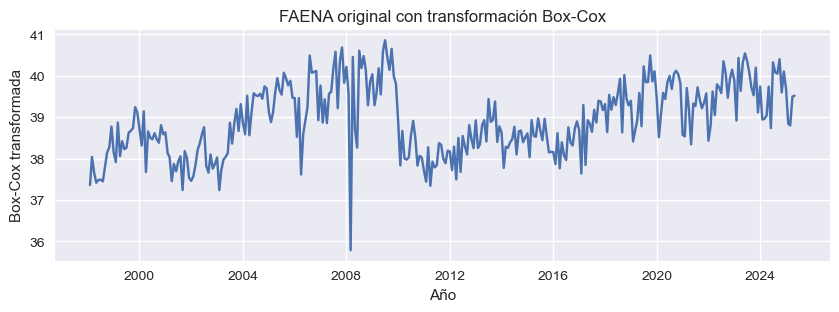

In [49]:
# Graficamos
graficar(faena_boxcox,
         titulo='FAENA original con transformación Box-Cox',
         xlabel='Año',
         ylabel='Box-Cox transformada',
         figsize=(10, 3))

In [50]:
# Test sobre los datos transformados
test_jarquebera(faena_boxcox)

===== Test de normalidad Jarque-Bera =====
Estadístico Jarque-Bera: 3.0836
p-valor: 0.2140
✅ No se rechaza la hipótesis nula: los residuos tienen distribución normal (al 5%)


---- 
## 7. Partición *train* y *test set*

#### Sobre los datos originales, con fines de visualización

In [ ]:
# Tomamos la columna de FAENA como una Serie
serie = df_faena[df_faena.columns[0]]

In [52]:
# Definimos el tamaño del corte: 90% para el train, 10% para el test
n_total = len(serie)
n_train = int(n_total * 0.9)

In [53]:
# División train / test
train = serie.iloc[:n_train]
test = serie.iloc[n_train:]

In [54]:
# Mostram tamaños
print(f"Observaciones totales: {n_total}")
print(f"Train: {len(train)} datos")
print(f"Test: {len(test)} datos")

Observaciones totales: 328
Train: 295 datos
Test: 33 datos


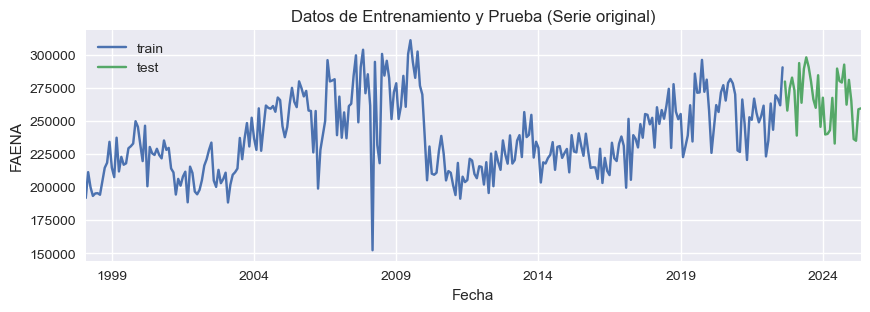

In [55]:
# Observamos los datos particionados
fig, ax = plt.subplots(figsize=(10, 3))
train.plot(ax=ax)
test.plot(ax=ax)
plt.title("Datos de Entrenamiento y Prueba (Serie original)")
plt.legend(['train', 'test'])
plt.xlabel('Fecha')
plt.ylabel('FAENA')
plt.show()

#### Sobre los datos transformados con Box-Cox
Ya que son los que vamos a utilizar para estimar el modelo

In [56]:
# Dividimos en train y test (90% - 10%) sobre los datos transformados
split_index = int(len(faena_boxcox) * 0.9)
train_boxcox = faena_boxcox.iloc[:split_index]
test_boxcox = faena_boxcox.iloc[split_index:]

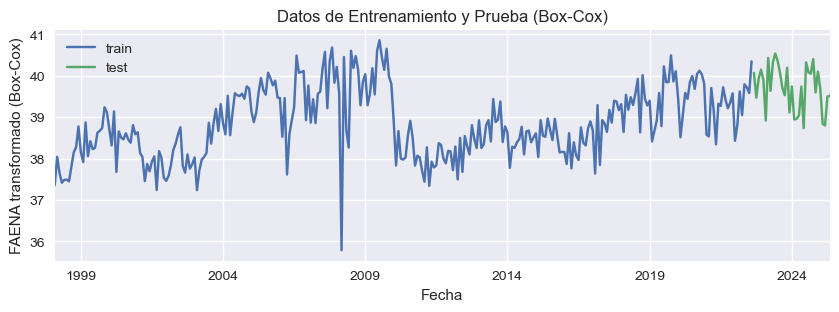

In [57]:
# Graficar
fig, ax = plt.subplots(figsize=(10, 3))
train_boxcox.plot(ax=ax)
test_boxcox.plot(ax=ax)
plt.title("Datos de Entrenamiento y Prueba (Box-Cox)")
plt.xlabel("Fecha")
plt.ylabel("FAENA transformado (Box-Cox)")
plt.legend(['train', 'test'])
plt.show()

-----
## 8. Estimación del modelo

A partir de lo observado gráficamente, y aplicando los tests correspondientes, podemos inferir un modelo SARIMA(p,d,q)(P,D,Q)s con los siguientes parámetros: 

Tendencia:
- Luego de aplicar la primera diferencia, los tests de ADF confirmaron estacionariedad. **d=1**

Estacionalidad: 
- El patrón visual de la serie y los picos en los lags 12 y 24 de la ACF indicaron una estacionalidad anual (mensual). Por lo tanto, se establece el periodo estacional en **s = 12**.
- Fue necesario aplicar una diferencia estacional (lag 12) para eliminarla **D=1**
- Pero no se eliminó por completo, por lo que se analizará una segunda diferenciación estacional **D=2**

Componente autorregresivo:
- En la PACF de la serie sin diferenciar, se observó un corte claro en el primer rezago, y el resto cae dentro del intervalo de confianza. **AR(1), p=1**

Componente de media móvil 
- Inicialmente intentamos con **MA(1), q=1**

Componente autorregresivo estacional: 
- La PACF mostró un pico significativo en el lag 12, lo que sugiere una dependencia estacional de tipo autorregresiva, entonces **P=1**

Componente media móvil estacional: 
- La ACF mostró picos significativos en lags 12 y 24, lo que sugiere una componente MA estacional.
- Por simplicidad y parsimonia, se prueba primero con **Q = 1**, pero luego se intenta un **Q=2**




#### Primer modelo: SARIMA(1,1,1)(1,1,1)12

In [82]:
# Propuesta ajustada para SARIMA sobre la serie de faena
order = (1, 1, 1)                # Componente no estacional: ARIMA(1,1,1)
seasonal_order = (1, 1, 1, 12)   # Componente estacional: SARIMA(1,1,1,12)


In [83]:
# Ajustamos el modelo SARIMA
modelo_sarima = SARIMAX(train_boxcox, 
                        order=order, 
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

results = modelo_sarima.fit(disp=False)

# Resumen del modelo
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  295
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -218.299
Date:                            Mon, 14 Jul 2025   AIC                            446.597
Time:                                    21:04:14   BIC                            464.552
Sample:                                02-01-1998   HQIC                           453.809
                                     - 08-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2366      0.094     -2.530      0.011      -0.420      -0.053
ma.L1         -0.5321      0.090   

#### Segundo modelo: SARIMA(1,1,1)(0,1,1)12

In [74]:
# Probamos quitando el componente autorregresivo estacional, ya que no es estadísticamente significativo
# Segunda propuesta
order_2 = (1, 1, 1)
seasonal_order_2 = (0, 1, 1, 12)

In [75]:
# Ajustamos el modelo SARIMA 2
modelo_sarima_2 = SARIMAX(train_boxcox,
                          order=order_2,
                          seasonal_order=seasonal_order_2,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

results_2 = modelo_sarima_2.fit(disp=False)
print(results_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  295
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -219.606
Date:                            Mon, 14 Jul 2025   AIC                            447.213
Time:                                    20:53:40   BIC                            461.577
Sample:                                02-01-1998   HQIC                           452.982
                                     - 08-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2292      0.100     -2.300      0.021      -0.424      -0.034
ma.L1         -0.5257      0.094   

#### Tercer modelo: SARIMA(1,1,1)(0,1,2)12

In [76]:
# Probamos agregando un componente media movil estacional Q = 2
# Tercera propuesta
order_3 = (1, 1, 1)          # ARIMA(p,d,q)
seasonal_order_3 = (0, 1, 2, 12)  # SARIMA(P,D,Q,s)

In [77]:
# Ajustamos el modelo SARIMA 3
modelo_sarima_3 = SARIMAX(train_boxcox, 
                        order=order_3, 
                        seasonal_order=seasonal_order_3,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

results_3 = modelo_sarima_3.fit(disp=False)

# Resumen del modelo
print(results_3.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  295
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -209.844
Date:                                 Mon, 14 Jul 2025   AIC                            429.687
Time:                                         20:53:45   BIC                            447.413
Sample:                                     02-01-1998   HQIC                           436.816
                                          - 08-01-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2327      0.096     -2.425      0.015      -0.421      -0

#### Cuarto modelo, SARIMA(1,1,1)(0,1,2)12 y agregamos un intercepto

In [78]:
# Debemos crear un vector de unos del mismo largo que el set de entrenamiento
exog_const = np.ones(len(train_boxcox))

In [79]:
# Ajustar el modelo SARIMA con intercepto
modelo_sarima_4 = SARIMAX(train_boxcox, 
                          order=order_3, 
                          seasonal_order=seasonal_order_3,
                          exog=exog_const,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

results_4 = modelo_sarima_4.fit(disp=False)

# Mostrar resumen
print(results_4.summary())

# El intercepto es significativo. 
# El segundo componente de mediamovil estacional deja de serlo

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  295
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -209.844
Date:                                 Mon, 14 Jul 2025   AIC                            431.687
Time:                                         20:53:52   BIC                            452.958
Sample:                                     02-01-1998   HQIC                           440.242
                                          - 08-01-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.948e-10      0.000   3.27e-06      1.000      -0.001       0

#### Quinto modelo, SARIMA(1,1,1)(0,1,1)12 con intercepto
- Sacamos el componente media movil estacional no significativo.
- Y dejamos el intercepto 

In [85]:
order_5 = (1, 1, 1)
seasonal_order_5 = (1, 1, 2, 12)


In [86]:
# Ajustar el modelo SARIMA con Q=1 (sin intercepto, ya que resultó no significativo)
modelo_sarima_5 = SARIMAX(train_boxcox, 
                          order=order_5, 
                          seasonal_order=seasonal_order_5,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

results_5 = modelo_sarima_5.fit(disp=False)

# Mostrar resumen
print(results_5.summary())


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  295
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -209.453
Date:                                 Mon, 14 Jul 2025   AIC                            430.905
Time:                                         21:15:24   BIC                            452.176
Sample:                                     02-01-1998   HQIC                           439.460
                                          - 08-01-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2254      0.102     -2.221      0.026      -0.424      -0

----
## 9. Elección de modelo
Creamos una tabla resumen con las principales características de los modelos probados

In [87]:
# Lista de modelos y su metadata
modelos = [
    {'nombre': 'Modelo 1', 'result': results, 'order': order, 'seasonal_order': seasonal_order, 'intercepto': False},
    {'nombre': 'Modelo 2', 'result': results_2, 'order': order_2, 'seasonal_order': seasonal_order_2, 'intercepto': False},
    {'nombre': 'Modelo 3', 'result': results_3, 'order': order_3, 'seasonal_order': seasonal_order_3, 'intercepto': False},
    {'nombre': 'Modelo 4', 'result': results_4, 'order': order_3, 'seasonal_order': seasonal_order_3, 'intercepto': True},
    {'nombre': 'Modelo 5', 'result': results_5, 'order': order_2, 'seasonal_order': seasonal_order_2, 'intercepto': True},
]

# Crear tabla
filas = []

for modelo in modelos:
    res = modelo['result']
    pred_train = res.fittedvalues
    rmse = np.sqrt(mean_squared_error(train_boxcox, pred_train))
    pvals = res.pvalues
    significativos = sum(p < 0.05 for p in pvals)

    filas.append({
        'Modelo': modelo['nombre'],
        'ARIMA(p,d,q)': modelo['order'],
        'Seasonal(P,D,Q,s)': modelo['seasonal_order'],
        'Intercepto': 'Sí' if modelo['intercepto'] else 'No',
        'AIC': round(res.aic, 2),
        'BIC': round(res.bic, 2),
        'RMSE Train': round(rmse, 2),
        'Coef. Significativos': f"{significativos}/{len(pvals)}"
    })

# Convertir a DataFrame
df_comparacion = pd.DataFrame(filas)
display(df_comparacion)


,Modelo,"ARIMA(p,d,q)","Seasonal(P,D,Q,s)",Intercepto,AIC,BIC,RMSE Train,Coef. Significativos
0,Modelo 1,"(1, 1, 1)","(1, 1, 1, 12)",No,446.60,464.55,2.73,2/5
1,Modelo 2,"(1, 1, 1)","(0, 1, 1, 12)",No,447.21,461.58,2.69,2/4
2,Modelo 3,"(1, 1, 1)","(0, 1, 2, 12)",No,429.69,447.41,2.69,2/5
3,Modelo 4,"(1, 1, 1)","(0, 1, 2, 12)",Sí,431.69,452.96,2.69,2/6
4,Modelo 5,"(1, 1, 1)","(0, 1, 1, 12)",Sí,430.91,452.18,2.60,2/6


Sin embargo: 
#### “La precisión de los pronósticos sólo se puede determinar considerando qué tan bien se desempeña un modelo con los nuevos datos que no se utilizaron al ajustar el modelo.”
Por lo que a continuación se calcularán distintas métricas sobre el conjunto de prueba. 


#### Generación de predicciones sobre el conjunto de testeo transformado con Box Cox

In [96]:
# Tamaño del test
n_test = len(test_boxcox)
print(n_test)

33


In [97]:
# Creamos una función que nos sirva para evaluar métricas
def evaluar_metricas(test_boxcox, test_pred):
    # 1. Cálculo de métricas
    mse  = mean_squared_error(test_boxcox, test_pred)
    mae  = mean_absolute_error(test_boxcox, test_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test_boxcox, test_pred) * 100

    # 2. Impresión formateada
    print(f'MSE:  {mse:.4f}')
    print(f'MAE:  {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.2f}%')

In [98]:
# Predicciones sobre el conjunto de testeo
exog_test = np.ones(n_test)

# 1. Modelo 1 (sin exógenas)
pred_1 = results.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 1 ---')
evaluar_metricas(test_boxcox, pred_1)
print()

# 2. Modelo 2 (sin exógenas)
pred_2 = results_2.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 2 ---')
evaluar_metricas(test_boxcox, pred_2)
print()

# 3. Modelo 3 (sin exógenas)
pred_3 = results_3.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 3 ---')
evaluar_metricas(test_boxcox, pred_3)
print()

# 4. Modelo 4 (con constante como exógena)
pred_4 = results_4.get_forecast(steps=n_test, exog=exog_test).predicted_mean
print('--- Métricas Modelo 4 ---')
evaluar_metricas(test_boxcox, pred_4)
print()

# 5. Modelo 5 (con constante como exógena)
pred_5 = results_5.get_forecast(steps=n_test, exog=exog_test).predicted_mean
print('--- Métricas Modelo 5 ---')
evaluar_metricas(test_boxcox, pred_5)
print()


--- Métricas Modelo 1 ---
MSE:  0.2151
MAE:  0.3656
RMSE: 0.4638
MAPE: 0.92%

--- Métricas Modelo 2 ---
MSE:  0.2316
MAE:  0.3731
RMSE: 0.4812
MAPE: 0.94%

--- Métricas Modelo 3 ---
MSE:  0.2224
MAE:  0.3722
RMSE: 0.4716
MAPE: 0.94%

--- Métricas Modelo 4 ---
MSE:  0.2224
MAE:  0.3722
RMSE: 0.4716
MAPE: 0.94%

--- Métricas Modelo 5 ---
MSE:  0.2324
MAE:  0.3776
RMSE: 0.4821
MAPE: 0.96%



##### Conclusiones
Modelo 1 logra el mejor RMSE y MAPE en test, pero tiene AIC/BIC más altos y menor parsimonia.

Modelo 3 es el mejor en criterios de información (AIC y BIC), con métricas de test apenas por encima del Modelo 1.

Modelos 4 y 5 no ofrecen mejoras claras ni en test ni en parsimonia, y agregan parámetros no significativos.

#### Elección de modelo
Primando por un modelo parsimonioso, se escoge aquel con menor error MAPE y además con menor cantidad de coeficientes significativos. Por lo tanto, queda seleccionado el **modelo 3**.

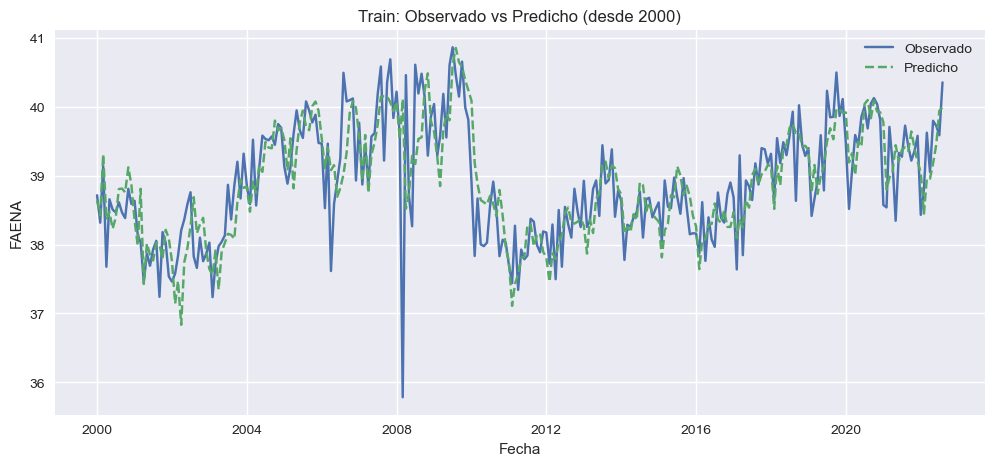

In [ ]:
# Filtrar desde el año 2000 en adelante
inicio = '2000-01-01'
train_boxcox_2000 = train_boxcox[train_boxcox.index >= inicio]
train_pred_2000 = train_pred[train_pred.index >= inicio]

plt.figure(figsize=(12, 5))
plt.plot(train_boxcox_2000, label='Observado')
plt.plot(train_pred_2000, label='Predicho', linestyle='--')
plt.title("Train: Observado vs Predicho")
plt.xlabel("Fecha")
plt.ylabel("FAENA")
plt.legend()
plt.grid(True)
plt.show()





In [ ]:
# Ajustamos el modelo SARIMA 3
modelo_sarima_3 = SARIMAX(train_boxcox, 
                        order=order_3, 
                        seasonal_order=seasonal_order_3,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

results_3 = modelo_sarima_3.fit(disp=False)

# Resumen del modelo
print(results_3.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  295
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -209.844
Date:                                 Mon, 14 Jul 2025   AIC                            429.687
Time:                                         20:53:45   BIC                            447.413
Sample:                                     02-01-1998   HQIC                           436.816
                                          - 08-01-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2327      0.096     -2.425      0.015      -0.421      -0

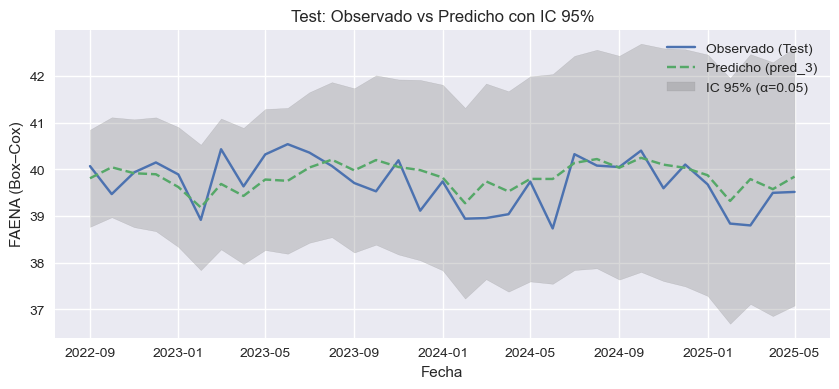

In [101]:
# Actual vs predicted en el conjunto de testeo

# 1. Calculamos de nuevo el forecast para obtener el IC
n_test = len(test_boxcox)
fc    = results_3.get_forecast(steps=n_test)            
pred_3 = fc.predicted_mean                              
ci     = fc.conf_int(alpha=0.05)                        

# 2. Grafico Observado vs Predicho + IC
plt.figure(figsize=(10, 4))
plt.plot(test_boxcox.index, test_boxcox, label='Observado (Test)')
plt.plot(pred_3.index,        pred_3,       linestyle='--', label='Predicho (pred_3)')

# Sombrear entre el límite inferior y superior
plt.fill_between(
    ci.index,
    ci.iloc[:, 0],   # límite inferior
    ci.iloc[:, 1],   # límite superior
    color='gray',
    alpha=0.3,
    label='IC 95% (α=0.05)'
)

plt.title("Test: Observado vs Predicho con IC 95%")
plt.xlabel("Fecha")
plt.ylabel("FAENA (Box–Cox)")
plt.legend()
plt.grid(True)
plt.show()


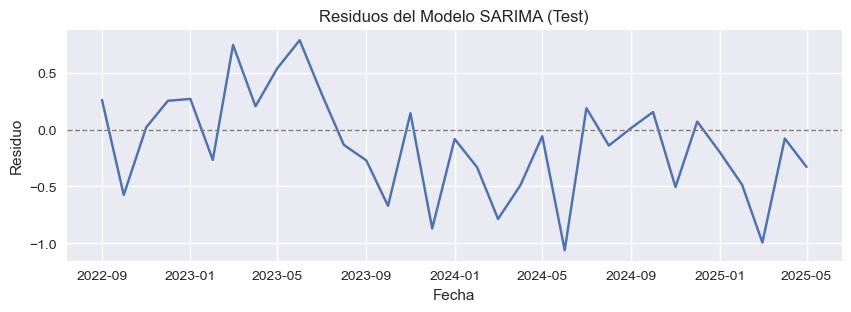

In [104]:
# 1. Calcular residuales en el conjunto de test (Box–Cox)
residuos_test = test_boxcox - pred_3

# 2. Gráfico de residuos sobre Test
plt.figure(figsize=(10, 3))
plt.plot(residuos_test, label='Residuo')
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title("Residuos del Modelo SARIMA (Test)")
plt.xlabel("Fecha")
plt.ylabel("Residuo")
plt.grid(True)
plt.show()

"Los residuos del Modelo SARIMA 3 sobre el conjunto de testeo presentan un comportamiento oscilante alrededor de cero sin patrones sistemáticos evidentes. Esto sugiere un buen ajuste del modelo, sin indicios de autocorrelación ni heterocedasticidad.

----
## 10. Análisis de diagnóstico

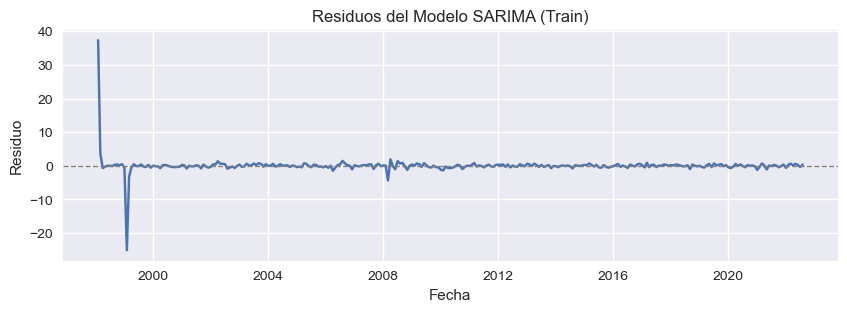

In [105]:
# Gráfico de residuos en el conjunto de entrenamiento 
residuos_train = results_3.resid

plt.figure(figsize=(10, 3))
plt.plot(residuos_train)
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title("Residuos del Modelo SARIMA (Train)")
plt.xlabel("Fecha")
plt.ylabel("Residuo")
plt.grid(True)
plt.show()

In [106]:
# Función para que grafique autocorrelaciones de los residuos del modelo 
def graficar_acf_pacf(serie, n_lags=50, titulo="Análisis de correlación temporal"):
    fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
    fig.suptitle(titulo, fontsize=12)
    plot_acf(serie, lags=n_lags, ax=axes[0], color='blue',
             vlines_kwargs={'colors':'blue'}, title='Autocorrelación (ACF)')
    plot_pacf(serie, lags=n_lags, ax=axes[1], color='green',
              vlines_kwargs={'colors':'green'}, method='ywm',
              title='Autocorrelación Parcial (PACF)')
    plt.tight_layout()
    plt.show()

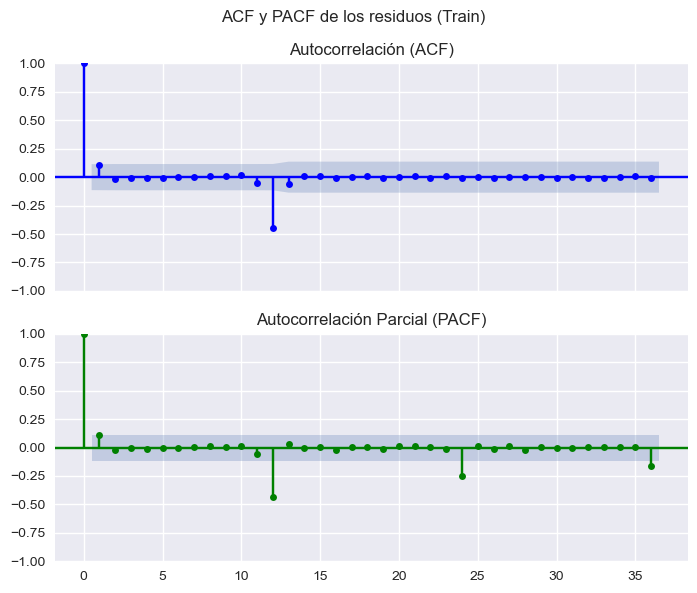

In [107]:
# Graficamos 
graficar_acf_pacf(residuos_train, n_lags=36, titulo="ACF y PACF de los residuos (Train)")

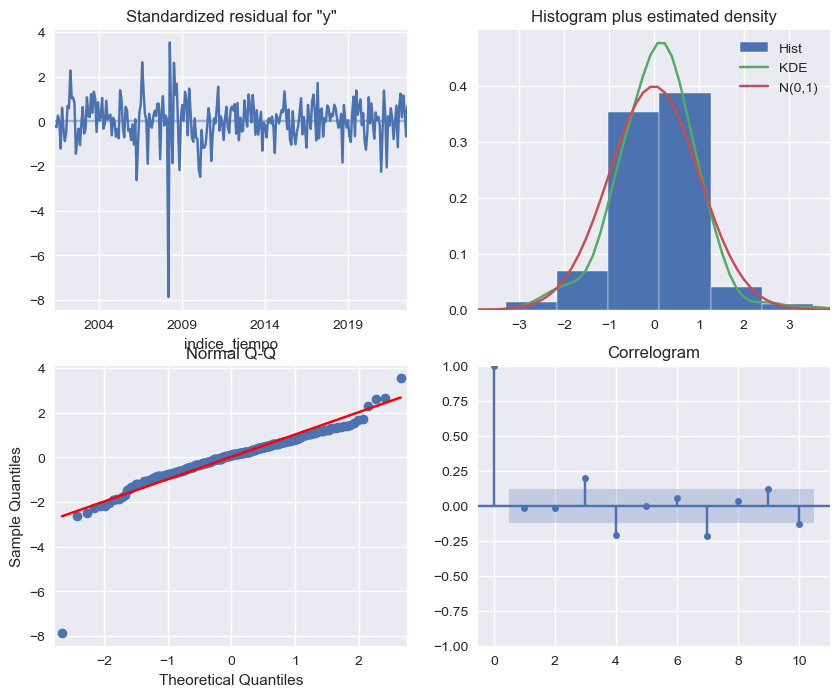

In [108]:
# Diagnóstico gráfico de residuos para el Modelo 3
fig_res_3 = results_3.plot_diagnostics(figsize=(10, 8))
plt.show()

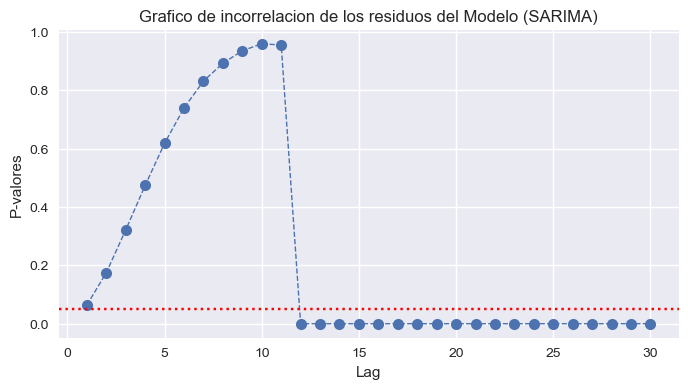

In [109]:
# Test de Ljung–Box y gráfico de p-valores para residuos del Modelo 3
Incorr_residuos_modelo3 = sm.stats.acorr_ljungbox(results_3.resid, lags=30)
plt.figure(figsize=(8,4))
plt.plot(Incorr_residuos_modelo3.lb_pvalue, marker='o', markersize=8,
         linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del Modelo (SARIMA)")
plt.xlabel("Lag")
plt.ylabel("P-valores")
plt.axhline(0.05, color='red', linestyle=':')  # nivel de significancia 5%
plt.grid(True)
plt.show()

Los primeros lags (hasta alrededor de 6) muestran p-valores > 0.05, pero a partir del lag 12 (y en adelante) caen por debajo del umbral, rechazando la hipótesis de “residuos no correlacionados”. Eso indica que aún hay autocorrelación en los residuos a nivel estacional, de modo que el modelo no logra capturar por completo esa dependencia.

----
## 11. Forecast 

In [110]:
# Ajustamos el modelo sarima a toda la serie, no solo el conjunto de entrenamiento
model_full = SARIMAX(faena_boxcox,
                     order=(1,1,1),
                     seasonal_order=(0,1,2,12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

results_full = model_full.fit(disp=False)

# Mostrar resumen
print(results_full.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  328
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -231.127
Date:                                 Tue, 15 Jul 2025   AIC                            472.254
Time:                                         22:05:45   BIC                            490.586
Sample:                                     02-01-1998   HQIC                           479.599
                                          - 05-01-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2381      0.089     -2.689      0.007      -0.412      -0

In [111]:
# Pronóstico a 12 meses 
n_forecast = 12
fc         = results_full.get_forecast(steps=n_forecast)
pred_bc    = fc.predicted_mean
ci_bc      = fc.conf_int(alpha=0.05)

In [112]:
# Invertir Box–Cox en pronóstico y CI
pred_orig = inv_boxcox(pred_bc, lambda_bc)
ci_orig = pd.DataFrame({
    'lower': inv_boxcox(ci_bc.iloc[:,0], lambda_bc),
    'upper': inv_boxcox(ci_bc.iloc[:,1], lambda_bc)
})

In [113]:
# Crear índice futuro de 12 meses
last_date    = faena_boxcox.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                             periods=n_forecast,
                             freq=faena_boxcox.index.freq or 'MS')
pred_orig.index = future_index
ci_orig.index   = future_index

In [114]:
# Reconstruir la serie histórica original
full_series = inv_boxcox(faena_boxcox, lambda_bc)

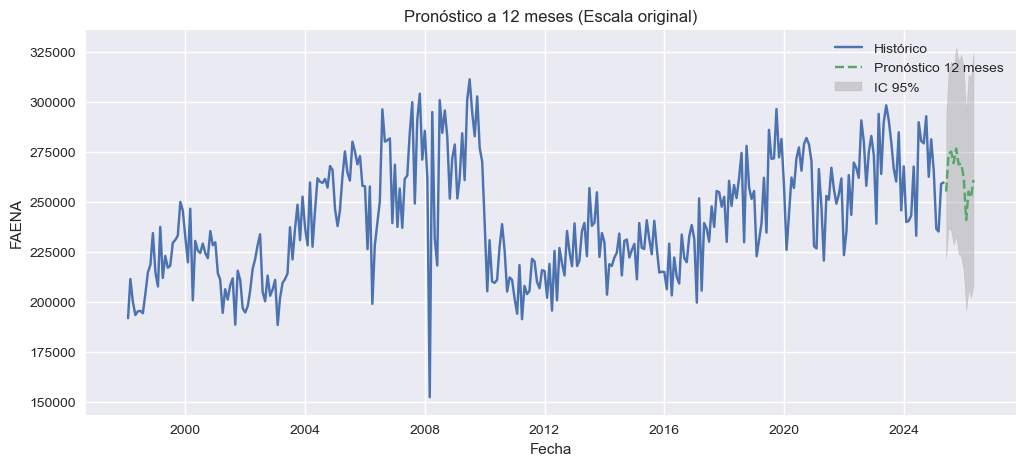

In [115]:
# 6. Graficar histórico + pronóstico + IC 95% (escala original)
plt.figure(figsize=(12,5))
plt.plot(full_series, label='Histórico')
plt.plot(pred_orig,   '--',   label='Pronóstico 12 meses')
plt.fill_between(ci_orig.index,
                 ci_orig['lower'],
                 ci_orig['upper'],
                 color='gray', alpha=0.3,
                 label='IC 95%')
plt.title("Pronóstico a 12 meses (Escala original)")
plt.xlabel("Fecha")
plt.ylabel("FAENA")
plt.legend()
plt.grid(True)
plt.show()

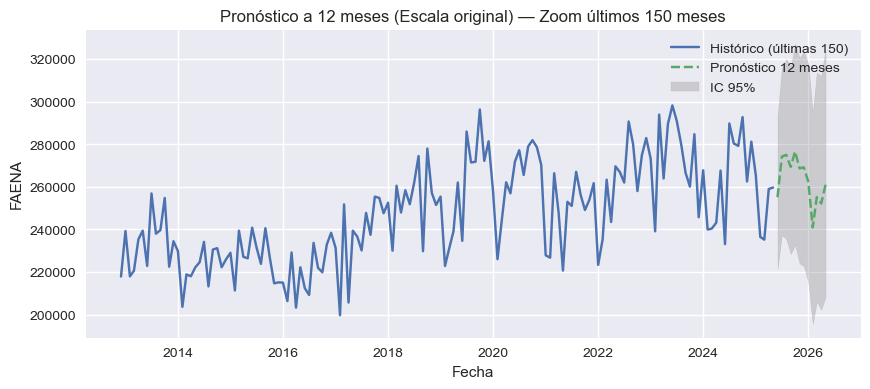

In [116]:
# Zoom para ver mejor el forecast
hist_tail = full_series.tail(150)

plt.figure(figsize=(10,4))
plt.plot(hist_tail, label='Histórico (últimas 150)')
plt.plot(pred_orig, '--', label='Pronóstico 12 meses')
plt.fill_between(ci_orig.index,
                 ci_orig['lower'],
                 ci_orig['upper'],
                 color='gray', alpha=0.3,
                 label='IC 95%')
plt.title("Pronóstico a 12 meses (Escala original) — Zoom últimos 150 meses")
plt.xlabel("Fecha")
plt.ylabel("FAENA")
plt.legend()
plt.grid(True)
plt.show()

----
## Fin del código!